In [3]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *
from rsna_retro.seutao import *

Loading imports


## Dsrc

In [5]:
dbunch = get_seutao_dbunch(Meta.df_comb1, np_file, csv_file, bs=64)

loading features
Done loading features


## Load

In [6]:
class NeuralNet(nn.Module):
    def __init__(self, n_classes=6, embed_size=2048, LSTM_UNITS=2048, DO = 0.3):
        super(NeuralNet, self).__init__()
        
#         self.embedding_dropout = SpatialDropout(0.0) #DO)
        
        self.lstm1 = nn.LSTM(embed_size, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(LSTM_UNITS * 2, LSTM_UNITS, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)
        self.linear2 = nn.Linear(LSTM_UNITS*2, LSTM_UNITS*2)

        self.linear = nn.Linear(LSTM_UNITS*2, n_classes)

    def forward(self, x):
        h_embedding = x

        h_embadd = torch.cat((h_embedding[:,:,:2048], h_embedding[:,:,:2048]), -1)
        
        h_lstm1, _ = self.lstm1(h_embedding)
        h_lstm2, _ = self.lstm2(h_lstm1)
        
        h_conc_linear1  = F.relu(self.linear1(h_lstm1))
        h_conc_linear2  = F.relu(self.linear2(h_lstm2))
        
#         print([x.shape for x in [h_lstm1, h_lstm2, h_conc_linear1, h_conc_linear2, h_embadd]])
        
        hidden = h_lstm1 + h_lstm2 + h_conc_linear1 + h_conc_linear2 + h_embadd

        output = self.linear(hidden)
        
        return output

In [7]:
class SeqHead(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 2048
        hidden = 96
        self.lstm = nn.LSTM(input_size=d_model, hidden_size=hidden, num_layers=2, bidirectional=True)
        self.head = nn.Sequential(
#             nn.Linear(hidden*2,hidden*4),
#             nn.ReLU(),
            nn.Linear(hidden*2,6)
        )
        
    def forward(self, x):
        feat, _ = self.lstm(x.transpose(0,1))
        return self.head(feat.transpose(0,1))

In [8]:
def get_feat_dbunch_feat(df, np_file, csv_file, bs=1, num_workers=8):
    print('loading features')
    features = np.load(str(np_file))
    prob_df = pd.read_csv(csv_file)
    sops = [Path(f).stem for f in prob_df.filename.values]
    feature_map = dict(zip(sops, features))
    print('Done loading features')

    pad_to = None if bs == 1 else max_seq_len
    dsrc = get_3d_dsrc(df, open_fn=OpenFeats(feature_map), pad_to=pad_to)
    return get_dbunch(dsrc, bs, [Cuda()], num_workers)


In [9]:
m = NeuralNet().cuda().half()

In [10]:
xb,yb = dbunch.one_batch()

In [11]:
m(xb).shape

torch.Size([64, 48, 6])

In [12]:
learn = get_learner(dbunch, m)

In [13]:
learn.add_cb(DePadLoss())

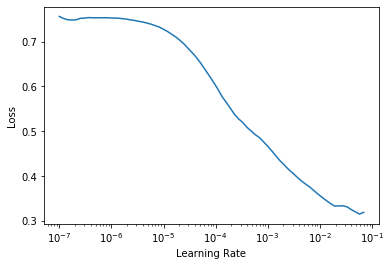

In [17]:
learn.lr_find()

## Train

In [ ]:
do_fit(learn, 10, 1e-2)
learn.save(f'runs/{name}-1')